## This notebook is for testing the SDK before using any scripts for data retrieval / live feed
- Make sure you have the .env file with the corrent variable names listed below before running the code

In [1]:
# Authentication for streaming data
from neurosity import NeurositySDK
from dotenv import load_dotenv
import os

load_dotenv()

neurosity = NeurositySDK({
    "device_id": os.getenv("NEUROSITY_DEVICE_ID")
})

neurosity.login({
    "email": os.getenv("NEUROSITY_EMAIL"),
    "password": os.getenv("NEUROSITY_PASSWORD")
})

In [2]:
# checking the info from the SDK
info = neurosity.get_info()
print(info)

OrderedDict({'channelNames': ['CP6', 'F6', 'C4', 'CP4', 'CP3', 'F5', 'C3', 'CP5'], 'channels': 8, 'deviceId': 'e425ea92bcd7bdae65a5c2b07322433d', 'deviceNickname': 'Emulator-E42', 'emulator': True, 'manufacturer': 'Neurosity, Inc', 'model': 'Emulator 2', 'modelName': 'Emulator', 'modelVersion': '2', 'osVersion': '14.5.0', 'samplingRate': 250})


# Raw Brainwaves Data

In [3]:
# Retrieving raw brainwaves and storing 1 epoch
import time
sample = 0

def callback(data):
    global sample
    sample = data
    
unsubscribe = neurosity.brainwaves_raw(callback) # the function returned from calling the api is used to stop the data feed

time.sleep(1)

unsubscribe()

In [4]:
import matplotlib.pyplot as plt
import numpy as np
# What one epoch looks like
# print(sample)

# Storing & Visualizing 
channels = ['CP6', 'F6', 'C4', 'CP4', 'CP3', 'F5', 'C3', 'CP5']
data = np.array(sample['data'])  
print(data)
print(data.shape)
print(sample['info'])

[[-10.33355712  -5.1959265   -0.46389117   3.12994159   4.77738486
    3.03379404  -0.52132179  -3.42644821  -5.98631998  -7.73391998
   -7.78538569  -7.35529122  -5.00026818   1.87516138  10.63511909
   15.49177391  12.43384493   3.39386623  -4.88955483  -7.84710738
   -5.09636559  -0.12045082   1.78172257   0.67945382   0.9730434 ]
 [ -6.05505139  -5.530393    -6.22287915 -10.22281266 -14.01631038
  -12.99839227  -7.54827563  -1.08315252   4.08297021   8.36416932
   14.82781638  23.61066224  28.01140414  21.50002163   5.71364072
   -9.43695351 -13.5832107   -4.06983915  12.29325835  24.82343544
   28.66930535  27.04105703  24.58525543  21.37959278  14.05963447]
 [ 17.39272322  23.25359961  27.15566331  26.06240837  21.49630899
   15.84748055   9.93804188   3.63564674  -4.20349703 -12.6117225
  -16.13287793 -11.15024701  -0.04134254  11.13558654  15.4733893
    9.75811823  -3.78468872 -19.4083783  -30.79331248 -35.58918477
  -35.01388275 -30.12292696 -22.89873622 -16.1615831  -10.1106

### Epoch Structure
-  the data is recieved as 8 rows, with each row being a channel, and each column being 1 timestamp with the duration between each other depending on the`samplingRate` attribute. 
    E.g. `samplingRate = 250` means 250 samples per second, each sample being 4 ms, and each epoch being 100 ms
- The values themselves range from -40 to +32 microvolts

In [5]:
# Accumilating 5 seconds worth of epochs
data = np.zeros((8,1))
def callback(new):
    new = np.array(new['data'])
    global data
    data = np.concatenate((data,new), axis=1)
    
unsubscribe = neurosity.brainwaves_raw(callback) # the function returned from calling the api is used to stop the data feed

time.sleep(5)

unsubscribe()
print(data)
print(data.shape)

[[  0.         -10.33355712  -5.1959265   -0.46389117   3.12994159
    4.77738486   3.03379404  -0.52132179  -3.42644821  -5.98631998
   -7.73391998  -7.78538569  -7.35529122  -5.00026818   1.87516138
   10.63511909  15.49177391  12.43384493   3.39386623  -4.88955483
   -7.84710738  -5.09636559  -0.12045082   1.78172257   0.67945382
    0.9730434 ]
 [  0.          -6.05505139  -5.530393    -6.22287915 -10.22281266
  -14.01631038 -12.99839227  -7.54827563  -1.08315252   4.08297021
    8.36416932  14.82781638  23.61066224  28.01140414  21.50002163
    5.71364072  -9.43695351 -13.5832107   -4.06983915  12.29325835
   24.82343544  28.66930535  27.04105703  24.58525543  21.37959278
   14.05963447]
 [  0.          17.39272322  23.25359961  27.15566331  26.06240837
   21.49630899  15.84748055   9.93804188   3.63564674  -4.20349703
  -12.6117225  -16.13287793 -11.15024701  -0.04134254  11.13558654
   15.4733893    9.75811823  -3.78468872 -19.4083783  -30.79331248
  -35.58918477 -35.01388275 -3

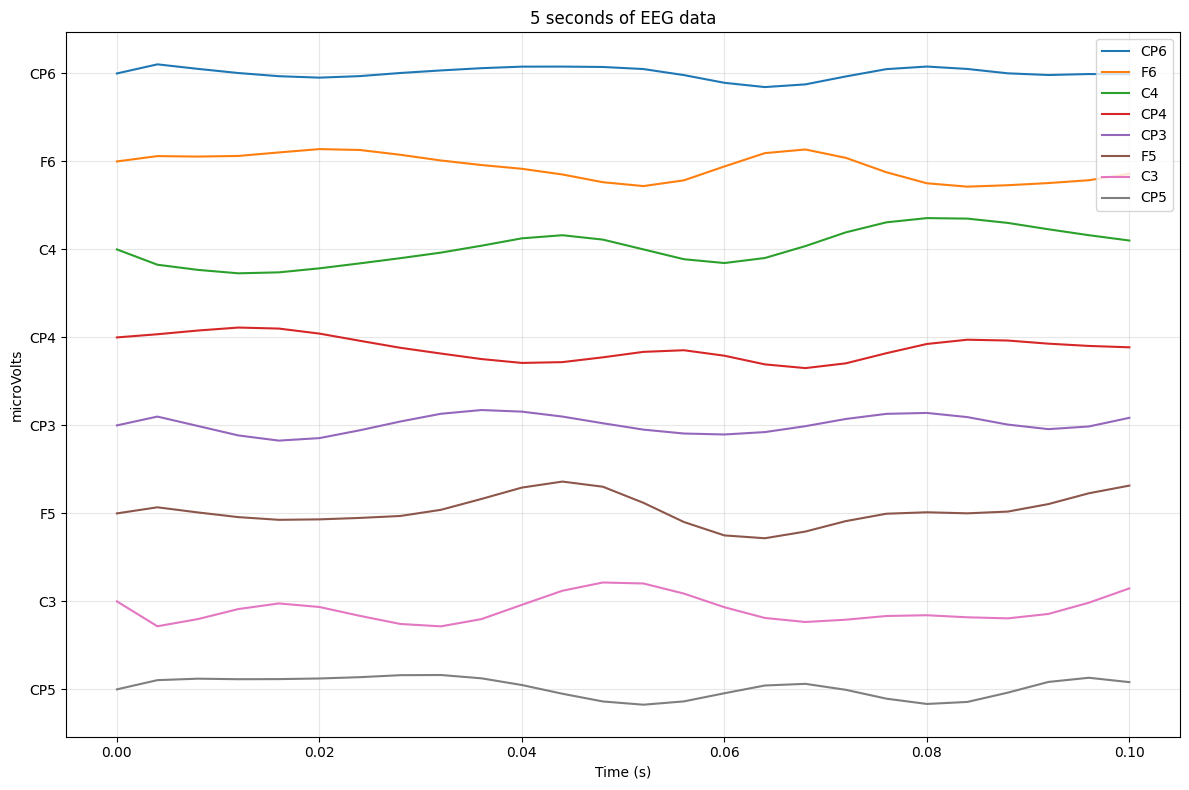

In [6]:
# Visualizing the 5 second window
n_channels, n_samples = data.shape
time = np.arange(n_samples) / 250  # assume 250 Hz sampling rate (adjust!)

plt.figure(figsize=(12, 8))

# Plot each channel with vertical offsets so they don’t overlap
offset = 100  # adjust spacing between signals
for i in range(n_channels):
    plt.plot(time, data[i] + i * offset, label=channels[i])

plt.yticks([i * offset for i in range(n_channels)], channels)
plt.gca().invert_yaxis()

plt.title("5 seconds of EEG data")
plt.xlabel("Time (s)")
plt.ylabel("microVolts")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

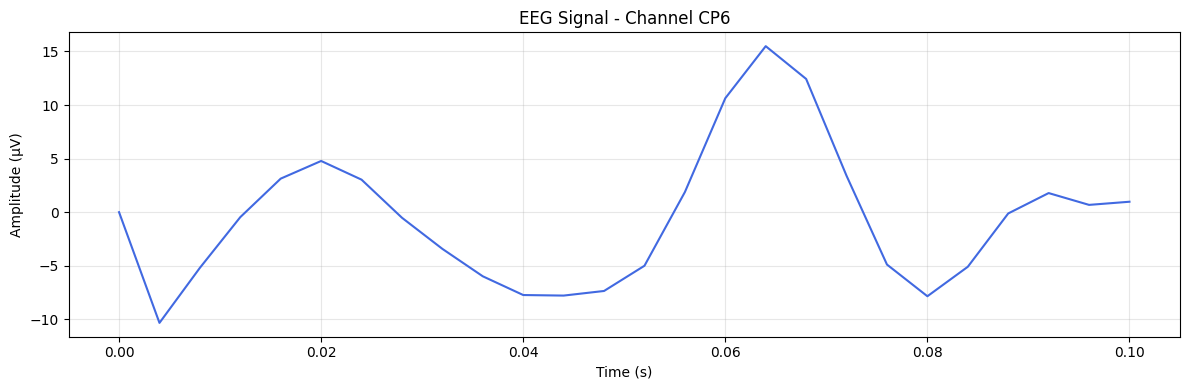

In [7]:
# Visualization for individual channels (e.g. "CP6")
channel_idx = channels.index("CP6")
channel_data = data[channel_idx]

# Sampling rate (adjust to your device)
fs = 250  
time = np.arange(channel_data.shape[0]) / fs

plt.figure(figsize=(12, 4))
plt.plot(time, channel_data, color="royalblue")
plt.title(f"EEG Signal - Channel {channels[channel_idx]}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Absolute Power

In [8]:
# Retrieve Absolute Power (AP) brainwaves
import time

ap_sample = None

def ap_callback(data):
    global ap_sample
    ap_sample = data
    print("Absolute Power Update:", data)

# To subscribe to absolute power stream
unsubscribe_ap = neurosity.brainwaves_power_by_band(ap_callback)

# Run for a few seconds
time.sleep(5)

# Stop the subscription
unsubscribe_ap()

print(f"Final Absolute Power Sample: {ap_sample}")

Absolute Power Update: {'data': {'alpha': [1.497302200735603, 2.8187227751566426, 2.8744916297689698, 4.968338652400541, 3.5616987938807276, 1.6622070992534141, 2.748024369291317, 4.793265800504291], 'beta': [2.9139558333591937, 2.098723911570561, 2.5591532119884577, 3.352577161748062, 3.301633796910887, 3.3338793287995196, 2.437867501442333, 2.384054641189485], 'delta': [1.2403187592007918, 1.826274359488462, 3.5418895437690177, 5.889666494828228, 2.244238953224757, 2.990341476369471, 6.223928648709878, 1.2024663603347645], 'gamma': [0.41524910675956866, 0.6224289138892973, 0.7179101008093277, 0.49079318834122554, 0.49103494906615996, 0.4838097671328335, 0.6721197664232937, 0.4387898012053568], 'theta': [1.927293886417468, 1.011900547021664, 3.462895677223436, 4.357982909745333, 1.4117261514573407, 3.7623803311922575, 7.217975898588227, 2.118664834054164]}, 'label': 'powerByBand'}
Final Absolute Power Sample: {'data': {'alpha': [1.497302200735603, 2.8187227751566426, 2.874491629768969

## Dictionary Structure
- there are 5 frequencies, and each contains an array of 8 elements for the 8 channels, showing the power in each channel

In [9]:

print(ap_sample['data'])


{'alpha': [1.497302200735603, 2.8187227751566426, 2.8744916297689698, 4.968338652400541, 3.5616987938807276, 1.6622070992534141, 2.748024369291317, 4.793265800504291], 'beta': [2.9139558333591937, 2.098723911570561, 2.5591532119884577, 3.352577161748062, 3.301633796910887, 3.3338793287995196, 2.437867501442333, 2.384054641189485], 'delta': [1.2403187592007918, 1.826274359488462, 3.5418895437690177, 5.889666494828228, 2.244238953224757, 2.990341476369471, 6.223928648709878, 1.2024663603347645], 'gamma': [0.41524910675956866, 0.6224289138892973, 0.7179101008093277, 0.49079318834122554, 0.49103494906615996, 0.4838097671328335, 0.6721197664232937, 0.4387898012053568], 'theta': [1.927293886417468, 1.011900547021664, 3.462895677223436, 4.357982909745333, 1.4117261514573407, 3.7623803311922575, 7.217975898588227, 2.118664834054164]}


# Calm/Focus Data

## Neurosity.calm() quick explanation:

neurosity.calm() streams a probability (0–1) that represents how calm the user is, based on EEG signals.

Difference from raw/absolute power:
Instead of giving you raw brainwave amplitudes (e.g. alpha, beta, gamma), it already applies Neurosity’s built-in model to estimate calmness.

A possible use case that we can use: 
We may define relaxed via low beta & high alpha, for example.

In [10]:
# Retrieve Focus/Calm Probability for 5 seconds
import time

def callback(data):
    print("Probability:", data)

# subscribing to focus and calm streams
focus_unsubscribe = neurosity.focus(callback)
calm_unsubscribe = neurosity.calm(callback)
# Run for a few seconds
time.sleep(5)

# Stop the subscription
focus_unsubscribe()
calm_unsubscribe()
print(f"Final Focus Sample: {sample}")

Probability: {'label': 'focus', 'metric': 'awareness', 'probability': 0.49961764058773794, 'timestamp': 1762214657059}
Probability: {'label': 'calm', 'metric': 'awareness', 'probability': 0.38917102150123306, 'timestamp': 1762214656619}
Final Focus Sample: {'data': [[-10.333557117617389, -5.195926504679793, -0.4638911745860326, 3.1299415921581546, 4.777384864393907, 3.0337940375601566, -0.5213217872394096, -3.426448210183685, -5.98631997719416, -7.733919980831309, -7.7853856941012385, -7.355291218182616, -5.000268179939774, 1.8751613830124771, 10.635119092282316, 15.49177391309583, 12.433844930795512, 3.393866228941823, -4.889554831957705, -7.847107376153423, -5.09636558969797, -0.12045082311171651, 1.781722571864024, 0.6794538228091094, 0.9730434037169873], [-6.0550513870788665, -5.530393004838377, -6.222879146415789, -10.222812659683214, -14.016310384588778, -12.99839226945565, -7.548275630018518, -1.0831525224318836, 4.082970205035723, 8.36416932332256, 14.827816380274925, 23.610662

In [11]:
# Test out callback function for data retrieval
focusList = []
def callback_focus(data):
    global focusList
    focusList.append([data['timestamp'], {data['label']: data['probability']}])

f_unsubscribe = neurosity.focus(callback_focus)
time.sleep(3)
f_unsubscribe()

print(focusList)

[[1762214657059, {'focus': 0.49961764058773794}]]


## Accelerometer() explanation: 

Each epoch has three acceleration values: x, y and z. For example: 

In [12]:
{
  "x": -0.02,
  "y": 0.99,
  "z": 0.07,
  "timestamp": 1635724527000
}


{'x': -0.02, 'y': 0.99, 'z': 0.07, 'timestamp': 1635724527000}

                                        
- The unit is expressed in g, where 1 g corresponds to the acceleration due to gravity on Earth.

- Values reflect both gravitational acceleration and any movement-induced acceleration.

- Accelerometer() focuses on movement, rather than specific brainwaves. 

##### By looking at accelerometer epochs, one can: 

- Detect when the user is moving.

- Flag those EEG segments as less reliable.

- Clean your dataset by removing or correcting for motion artifacts.


In [13]:
# Callback for accelerometer
def accelerometer_test(data):
    ts = time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(data['timestamp']/1000))
    print(f"[ACCEL] {ts} | x={data['x']:.3f}, y={data['y']:.3f}, z={data['z']:.3f}")

# Subscribe for 5 seconds
unsubscribe = neurosity.accelerometer(accelerometer_test)
print("Collecting accelerometer epochs for 5 seconds...")
time.sleep(5)
unsubscribe() 

## Kinesis() explanation: 

                                        
- Each epoch represents a prediction of a user action such as blink or nod. 

- The SDK provides a label for each of the discrete user actions. 

For example: 

In [14]:
{
  "label": "jump",
  "confidence": 0.87,
  "timestamp": 1635724527000
}


{'label': 'jump', 'confidence': 0.87, 'timestamp': 1635724527000}

- label:  Indicates the specific action detected. This can be one of the standard gestures (e.g., push, pull, left, right) or a label we have trained (e.g., jump, blink, nod).

- confidence:  A value between 0 and 1 that expresses how certain the system is about the detected action.

- timestamp : Records the exact moment the prediction was made, given in epoch time (milliseconds).

In [15]:
# Callback for kinesis
def kinesis_test(data):
    ts = time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(data['timestamp']/1000))
    print(f"[KINESIS] {ts} | label={data['label']} | confidence={data['confidence']:.2f}")

# Subscribe for 5 seconds with a custom label
unsubscribe = neurosity.kinesis("jump", kinesis_test)
print("Collecting kinesis epochs for 5 seconds...")
time.sleep(5)
unsubscribe()


### PSD explanation(): 

 - Power Spectral Density (PSD) represents how the power of a signal is distributed across different frequency components.